In [2]:
import pickle
import torch
import sklearn
from tqdm import tqdm
import numpy as np
from asif import ASIF, extract_candidate_sets_from_clusters, compute_embedding
from transformers import AutoTokenizer, AutoModel
from matplotlib import pyplot as plt
from datasets import Dataset, load_dataset
from torch.utils.data import DataLoader

/home/luigi/anaconda3/envs/chocolm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def elbow(X, cluster_sizes, label = "Elbow curve"):
    distorsions = []
    result = []
    for k in tqdm(cluster_sizes):
        kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=k)
        kmeans.fit(X)
        distorsions.append(kmeans.inertia_)
        result.append(kmeans)
    fig = plt.figure(figsize=(15, 5))
    plt.plot(cluster_sizes, distorsions)
    plt.xticks(cluster_sizes)
    plt.grid(True)
    plt.title(label)
    return result

In [4]:
embedding_mode = "hs"

train_lyrics = pickle.load(open("experimental_data/train_lyrics.pkl", "rb"))
train_chords = pickle.load(open("experimental_data/train_chords.pkl", "rb"))

test_lyrics = pickle.load(open("experimental_data/test_lyrics.pkl", "rb"))
test_chords = pickle.load(open("experimental_data/test_chords.pkl", "rb"))

train_lyrics_embeddings = pickle.load(open(f"experimental_data/train_lyrics_embeddings_{embedding_mode}.pkl", "rb"))
train_chords_embeddings = pickle.load(open(f"experimental_data/train_chords_embeddings_{embedding_mode}.pkl", "rb"))

test_lyrics_embeddings = pickle.load(open(f"experimental_data/test_lyrics_embeddings_{embedding_mode}.pkl", "rb"))
test_chords_embeddings = pickle.load(open(f"experimental_data/test_chords_embeddings_{embedding_mode}.pkl", "rb"))

In [5]:
len(set(train_chords) - set(test_chords))

163058

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:29<00:00,  3.70s/it]


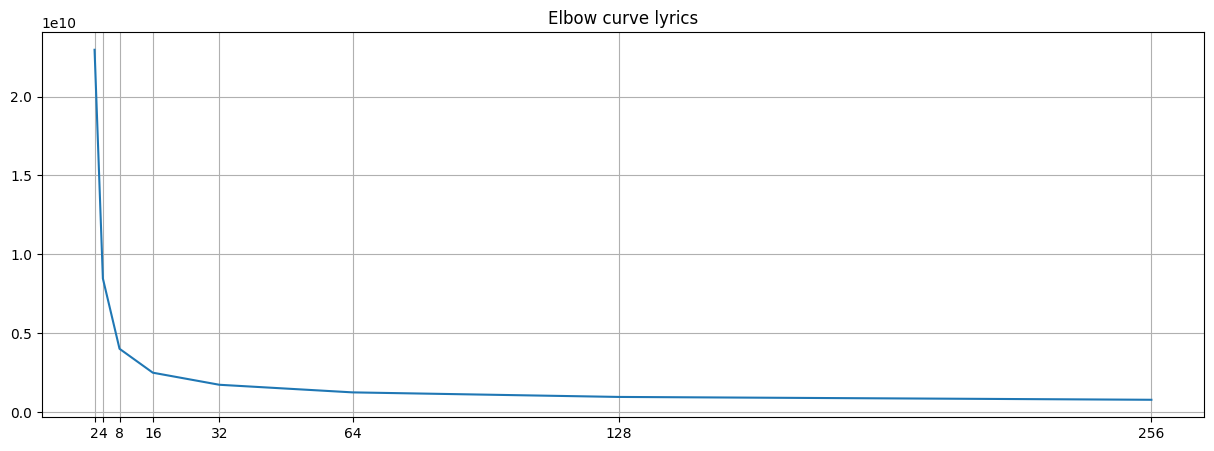

In [6]:
cluster_sizes = [2**p for p in range(1, 9)]
kmeans_runs_lyrics = elbow(train_lyrics_embeddings.numpy(), cluster_sizes, "Elbow curve lyrics")

100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


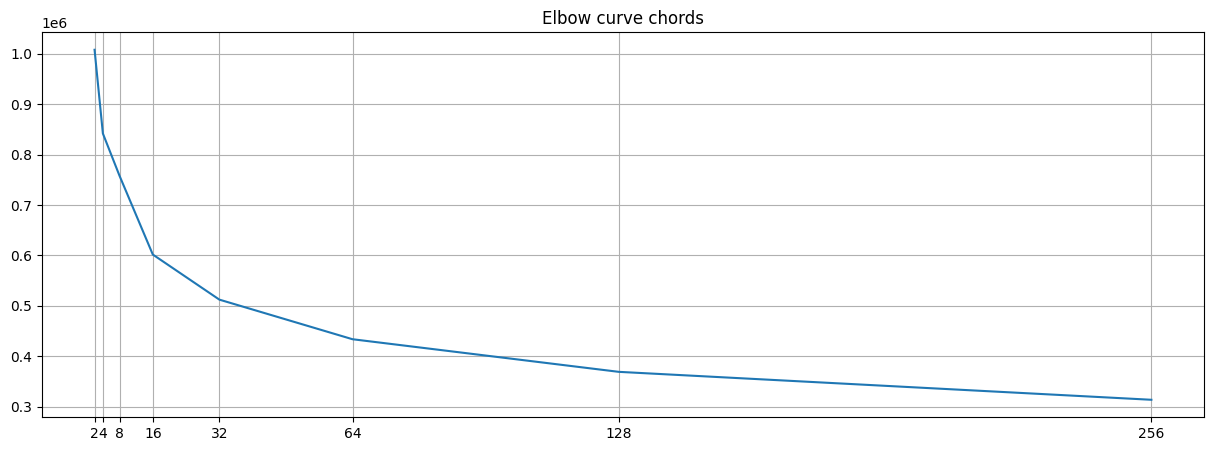

In [7]:
cluster_sizes = [2**p for p in range(1, 9)]
kmeans_runs_chords = elbow(train_chords_embeddings.numpy(), cluster_sizes, "Elbow curve chords")

In [8]:
# choose k = 8 for lyrics
kmeans_lyrics = kmeans_runs_lyrics[2]
# choose k = 16 for chords
kmeans_chords = kmeans_runs_chords[3]

In [9]:
lyrics_candidates = extract_candidate_sets_from_clusters(kmeans_lyrics, train_lyrics)
chords_candidates = extract_candidate_sets_from_clusters(kmeans_chords, train_chords)

In [10]:
asif = ASIF(
    lyrics_candidates,
    chords_candidates,
    torch.from_numpy(kmeans_lyrics.cluster_centers_),
    torch.from_numpy(kmeans_chords.cluster_centers_),
    train_lyrics_embeddings,
    train_chords_embeddings
)

In [ ]:
chunk_size = 1000
predictions = []

for i in tqdm(range(0, len(test_lyrics), chunk_size)):
    test_relative_coordinates_lyrics = asif.compute_relative_coordinates_vs_space1(test_lyrics_embeddings[i:i+chunk_size])
    test_relative_coordinates_lyrics = test_relative_coordinates_lyrics.to
    pred_chunk = (1 / (1 + torch.cdist(test_relative_coordinates_lyrics, asif.candidate_embeddings2_rc))).argmax(dim=1)
    predictions.extend(pred_chunk)

  0%|          | 0/705 [00:38<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 10.48 GiB. GPU 0 has a total capacity of 23.58 GiB of which 1.10 GiB is free. Process 1684732 has 1.03 GiB memory in use. Including non-PyTorch memory, this process has 21.42 GiB memory in use. Of the allocated memory 21.13 GiB is allocated by PyTorch, and 5.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [30]:
sim = (1 / (1 + torch.cdist(test_relative_coordinates_lyrics, asif.candidate_embeddings2_rc)))

In [35]:
sim.argmax(dim=1)[0]

tensor(10)

In [36]:
test_chords[0]

'C:maj A:min7'

In [41]:
asif.candidates2[10].index(test_chords[0])

9471